In [17]:
import os
import tensorflow as tf
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import json

physical_devices = tf.config.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [18]:
# define user here
username = "user1"

In [23]:
# import csv files
# problem with this method is that it imports in a weird order, as in jan 1 is not always the first file imported, and jan 2 won't be the second even if jan 1 is the first
data_dir = '/home/acapskyrim/projects/psm/psm_generate/json_data'
combined_data = pd.DataFrame()
counter = 0 # this is just for getting pretty plots

for filename in os.listdir(data_dir):
    if username in filename:
#         dataset = pd.read_csv(os.path.join(data_dir, filename), parse_dates=[0])
#         dataset.columns = ['Time', 'Beacon_1', 'Beacon_2', 'Beacon_3', 'Beacon_4', 'Beacon_5']
#         dataset.set_index('Time', inplace=True)
        dataset = pd.read_json(os.path.join(data_dir, filename),orient='split',convert_dates=['time'])
        dataset.set_index('time', inplace=True)
        combined_data = combined_data.append(dataset)
# combined_data.set_index('Time', inplace=True)
#     counter = counter + 1
#     if counter == 1:
#         break

In [24]:
# set train and test samples
train_size = int(len(combined_data) * 0.90)
test_size = len(combined_data) - train_size
train, test = combined_data.iloc[0:train_size], combined_data.iloc[train_size:len(combined_data)]
print(train.shape, test.shape)
print(combined_data)

(7905, 5) (879, 5)
                     Beacon_1  Beacon_2  Beacon_3  Beacon_4  Beacon_5
time                                                                 
2020-04-15 16:00:00        89        40        50        20        26
2020-04-15 17:00:00        80        50        47        20        20
2020-04-15 18:00:00        80        37        50        10        25
2020-04-15 19:00:00        83        40        54        17        20
2020-04-15 20:00:00        86        40        50        18        29
...                       ...       ...       ...       ...       ...
2020-08-15 11:00:00        30        40        80        70        50
2020-08-15 12:00:00        24        40        80        61        50
2020-08-15 13:00:00        80        47        41        20        20
2020-08-15 14:00:00        85        34        50        20        22
2020-08-15 15:00:00        79        39        42        20        10

[8784 rows x 5 columns]


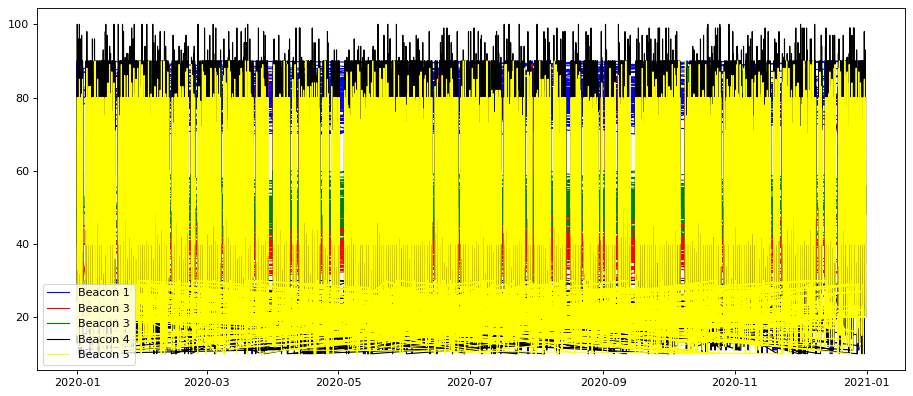

In [25]:
# visualize data
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Beacon_1'], label="Beacon 1", color='blue', animated=True, linewidth=1)
ax.plot(train['Beacon_2'], label="Beacon 3", color='red', animated=True, linewidth=1)
ax.plot(train['Beacon_3'], label="Beacon 3", color='green', animated=True, linewidth=1)
ax.plot(train['Beacon_4'], label="Beacon 4", color='black', animated=True, linewidth=1)
ax.plot(train['Beacon_5'], label="Beacon 5", color='yellow', animated=True, linewidth=1)

plt.legend(loc='lower left')
plt.show()

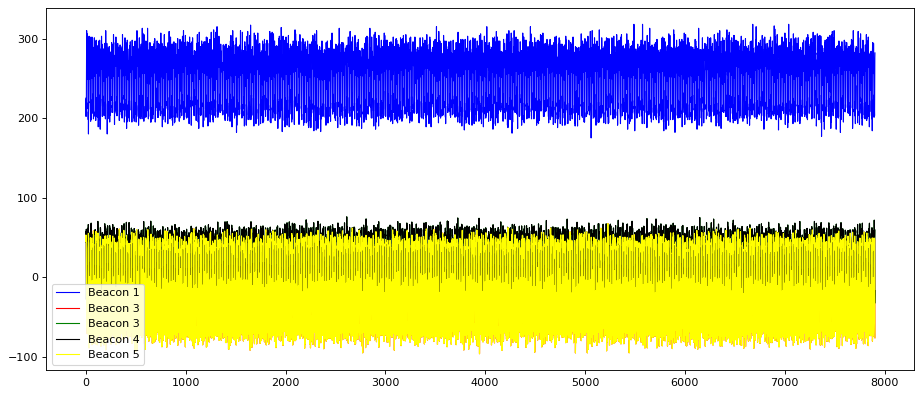

In [26]:
# fourier transforms. just out of curiosity
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label="Beacon 1", color='blue', animated=True, linewidth=1)
ax.plot(train_fft[:,1].real, label="Beacon 3", color='red', animated=True, linewidth=1)
ax.plot(train_fft[:,2].real, label="Beacon 3", color='green', animated=True, linewidth=1)
ax.plot(train_fft[:,3].real, label="Beacon 4", color='black', animated=True, linewidth=1)
ax.plot(train_fft[:,4].real, label="Beacon 5", color='yellow', animated=True, linewidth=1)

plt.legend(loc='lower left')
plt.show()

In [27]:
#reserved for normalization if needed
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train)
x_test = scaler.transform(test)
scaler_filename = username + "_scaler_data"
joblib.dump(scaler, scaler_filename)

['user1_scaler_data']

In [28]:
#reshaping the data
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [29]:
#can't reshape an already reshaped shape. so printing is in separate cell
print("Train shape: ", x_train.shape)
print("Test shape: ", x_test.shape)
num_features = x_train.shape[2]

Train shape:  (7905, 1, 5)
Test shape:  (879, 1, 5)


In [30]:
# Here's the fun stuff. Neural network definition. we usin autoencoders for this
# first one is using LSTM, more with others later
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, callbacks

def autoencoder_model(x, num):
    inputs = Input(shape=(x.shape[1], x.shape[2]))
    l1 = LSTM(num*num, activation='relu', return_sequences=True,
             kernel_regularizer=regularizers.l2(0.00))(inputs)
    l2 = LSTM(num, activation='relu', return_sequences=False)(l1)
    l3 = RepeatVector(x.shape[1])(l2)
    l4 = LSTM(num, activation='relu', return_sequences=True)(l3)
    l5 = LSTM(num*num, activation='relu', return_sequences=True)(l4)
    output = TimeDistributed(Dense(x.shape[2]))(l5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [31]:
# let's actually build the network
model = autoencoder_model(x_train, num_features)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 5)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 25)             3100      
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 620       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 5)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 5)              220       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 25)             3100      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 5)             

In [32]:
# training time
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", restore_best_weights=True, min_delta=0.0005, patience=5)
nb_epochs = 100
batch_size = 10
history = model.fit(x_train, x_train, epochs=nb_epochs, batch_size=batch_size,
                   validation_split=0.1, callbacks=[callback]).history
len(history['loss'])

Epoch 1/100
712/712 [==============================] - 9s 13ms/step - loss: 0.1742 - val_loss: 0.0999
Epoch 2/100
712/712 [==============================] - 8s 12ms/step - loss: 0.0894 - val_loss: 0.0787
Epoch 3/100
712/712 [==============================] - 8s 12ms/step - loss: 0.0782 - val_loss: 0.0759
Epoch 4/100
712/712 [==============================] - 8s 12ms/step - loss: 0.0763 - val_loss: 0.0746
Epoch 5/100
712/712 [==============================] - 9s 12ms/step - loss: 0.0751 - val_loss: 0.0738
Epoch 6/100
712/712 [==============================] - 8s 12ms/step - loss: 0.0743 - val_loss: 0.0737
Epoch 7/100
712/712 [==============================] - 8s 12ms/step - loss: 0.0736 - val_loss: 0.0722
Epoch 8/100
712/712 [==============================] - 8s 12ms/step - loss: 0.0721 - val_loss: 0.0698
Epoch 9/100
712/712 [==============================] - 8s 12ms/step - loss: 0.0666 - val_loss: 0.0623
Epoch 10/100
712/712 [==============================] - 9s 12ms/step - loss: 0.061

35

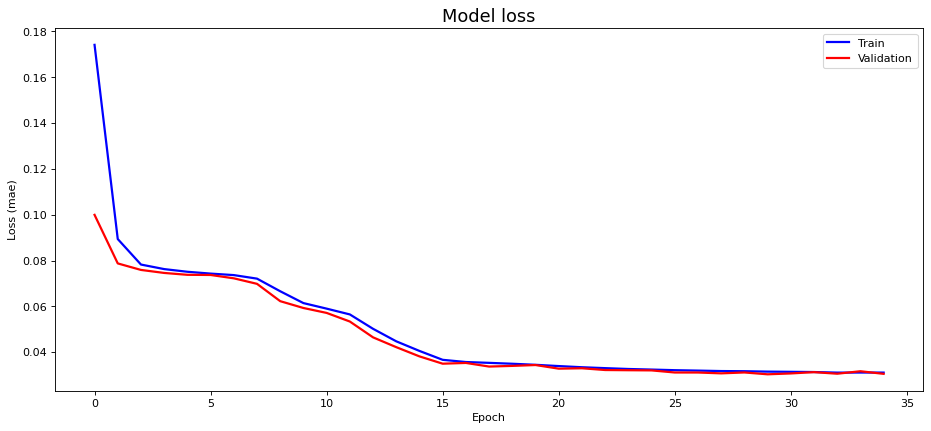

In [33]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

0.0680582585183401


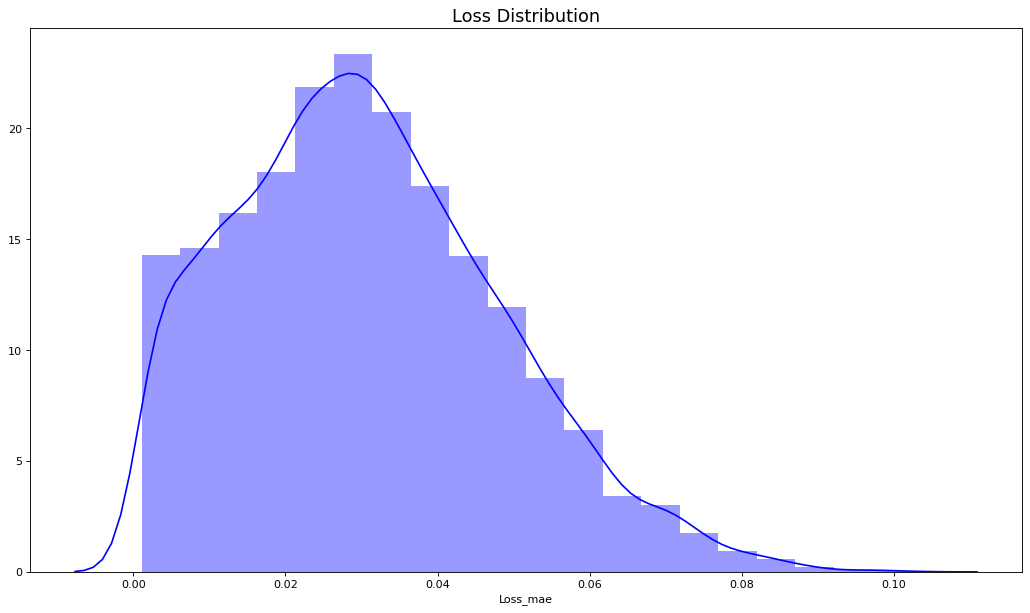

In [34]:
# loss distribution to determine threshold for anomaly
x_pred = model.predict(x_train)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns=train.columns)
x_pred.index = train.index

scored = pd.DataFrame(index=train.index)
xtrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(x_pred - xtrain), axis=1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)

scoreSorted = np.sort(scored['Loss_mae'])
threshold = scoreSorted[int(0.97 * len(scoreSorted))]
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue');

print(threshold)

In [35]:
# do anomaly thingy on the test set
x_pred = model.predict(x_test)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns=test.columns)
x_pred.index = test.index

scored = pd.DataFrame(index=test.index)
xtest = x_test.reshape(x_test.shape[0], x_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(x_pred-xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

countAnom = 0
for i in range(len(scored)):
    if scored['Anomaly'][i] == True:
        countAnom = countAnom + 1
        
print(countAnom)

23


In [36]:
x_pred_train = model.predict(x_train)
x_pred_train = x_pred_train.reshape(x_pred_train.shape[0], x_pred_train.shape[2])
x_pred_train = pd.DataFrame(x_pred_train, columns=test.columns)
x_pred_train.index = train.index

scored_train = pd.DataFrame(index=test.index)
scored_train['Loss_mae'] = np.mean(np.abs(x_pred_train-xtrain), axis = 1)
scored_train['Threshold'] = threshold
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

countAnom = 0
for i in range(len(scored_train)):
    if scored_train['Anomaly'][i] == True:
        countAnom = countAnom + 1
        
print(countAnom)

0


<AxesSubplot:xlabel='time'>

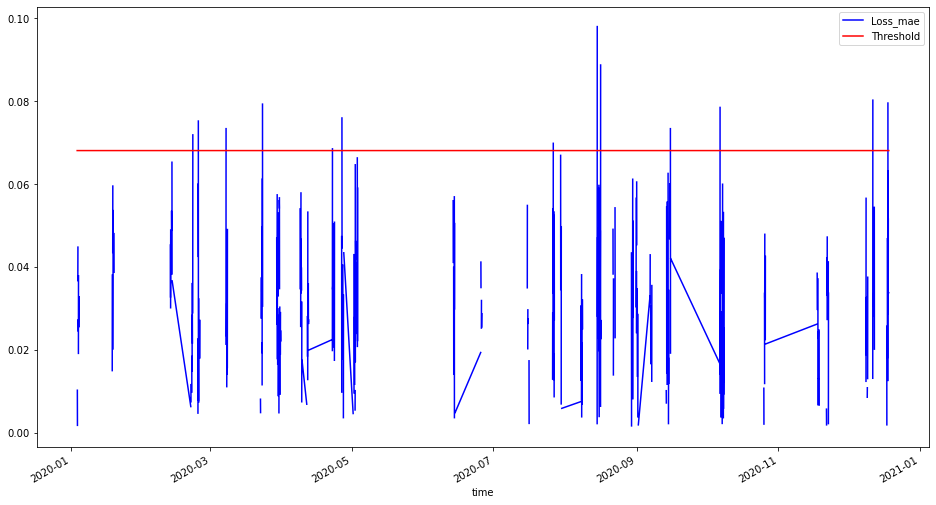

In [37]:
scored.plot( figsize=(16,9), color=['blue','red'])

In [38]:
# saves the model to a file for use
model_name = username + "_model.h5"
threshold_name = username + "_threshold"

model.save(model_name)
joblib.dump(threshold, threshold_name)
tf.keras.backend.clear_session()